# Comparison between grid search and successive halving

This example compares the parameter search performed by HalvingGridSearchCV and GridSearchCV.


In [109]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.svm import SVC

In [110]:
# get some data

rng = np.random.RandomState(0)
X, y = datasets.make_classification(n_samples=1000, random_state=rng)

In [112]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-1.063780,0.676409,1.069356,-0.217580,0.460215,-0.399167,-0.079188,1.209385,-0.785315,-0.172186,-1.085357,-0.993119,0.306935,0.064058,-1.054233,-0.527496,-0.074183,-0.355628,1.057214,-0.902592
1,0.070848,-1.695281,2.449449,-0.530494,-0.932962,2.865204,2.435729,-1.618500,1.300717,0.348402,0.544934,0.225324,0.605563,-0.192101,-0.068027,0.971681,-1.792048,0.017083,-0.375669,-0.623236
2,0.940284,-0.492146,0.677956,-0.227754,1.401753,1.231653,-0.777464,0.015616,1.331713,1.084773,-0.978052,-0.050120,0.948386,-0.173428,-0.477672,0.760896,1.001158,-0.069464,1.359046,-1.189590
3,-0.299517,0.759890,0.182803,-1.550233,0.338218,0.363241,-2.100525,-0.438068,-0.166393,-0.340835,0.424356,1.178724,2.831480,0.142414,-0.202819,2.405715,0.313305,0.404356,-0.287546,-2.847803
4,-2.630627,0.231034,0.042463,0.478851,1.546742,1.637956,-1.532072,-0.734445,0.465855,0.473836,0.989814,-1.061194,-0.888880,1.238409,-0.572829,-1.275339,1.003007,-0.477128,0.098536,0.527804


In [114]:
pd.Series(y).value_counts()

,count
0,502
1,498


In [116]:
gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {"gamma": gammas, "C": Cs}

In [117]:
clf = SVC(random_state=rng)

In [118]:
tic = time()
gsh = HalvingGridSearchCV(
    estimator=clf, param_grid=param_grid, factor=2, random_state=rng
)
gsh.fit(X, y)
gsh_time = time() - tic
print(gsh_time)

2.3008947372436523


In [119]:
tic = time()
gs = GridSearchCV(estimator=clf, param_grid=param_grid)
gs.fit(X, y)
gs_time = time() - tic
print(gs_time)

9.047117471694946


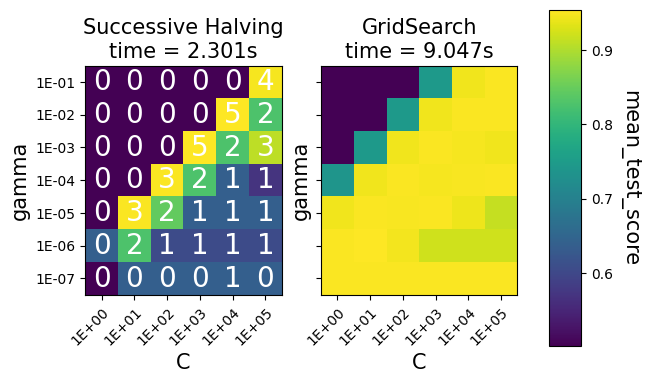

In [123]:
def make_heatmap(ax, gs, is_sh=False, make_cbar=False):
    """Helper to make a heatmap."""
    results = pd.DataFrame(gs.cv_results_)
    results[["param_C", "param_gamma"]] = results[["param_C", "param_gamma"]].astype(
        np.float64
    )
    if is_sh:
        # SH dataframe: get mean_test_score values for the highest iter
        scores_matrix = results.sort_values("iter").pivot_table(
            index="param_gamma",
            columns="param_C",
            values="mean_test_score",
            aggfunc="last",
        )
    else:
        scores_matrix = results.pivot(
            index="param_gamma", columns="param_C", values="mean_test_score"
        )

    im = ax.imshow(scores_matrix)

    ax.set_xticks(np.arange(len(Cs)))
    ax.set_xticklabels(["{:.0E}".format(x) for x in Cs])
    ax.set_xlabel("C", fontsize=15)

    ax.set_yticks(np.arange(len(gammas)))
    ax.set_yticklabels(["{:.0E}".format(x) for x in gammas])
    ax.set_ylabel("gamma", fontsize=15)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    if is_sh:
        iterations = results.pivot_table(
            index="param_gamma", columns="param_C", values="iter", aggfunc="max"
        ).values
        for i in range(len(gammas)):
            for j in range(len(Cs)):
                ax.text(
                    j,
                    i,
                    iterations[i, j],
                    ha="center",
                    va="center",
                    color="w",
                    fontsize=20,
                )

    if make_cbar:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel("mean_test_score", rotation=-90, va="bottom", fontsize=15)


fig, axes = plt.subplots(ncols=2, sharey=True)
ax1, ax2 = axes

make_heatmap(ax1, gsh, is_sh=True)
make_heatmap(ax2, gs, make_cbar=True)

ax1.set_title("Successive Halving\ntime = {:.3f}s".format(gsh_time), fontsize=15)
ax2.set_title("GridSearch\ntime = {:.3f}s".format(gs_time), fontsize=15)

plt.show()

The heatmaps show the mean test score of the parameter combinations for an SVC instance. The HalvingGridSearchCV also shows the iteration at which the combinations where last used. The combinations marked as 0 were only evaluated at the first iteration, while the ones with 5 are the parameter combinations that are considered the best ones.

We can see that the HalvingGridSearchCV class is able to find parameter combinations that are just as accurate as GridSearchCV, in much less time.